In [3]:
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import pipeline
import sklearn.datasets
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm

7. Fit some of the non-linear models investigated in this chapter to the
Auto data set. Is there evidence for non-linear relationships in this
data set? Create some informative plots to justify your answer.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Auto.csv')#, index_col=0)
df
df = df[pd.to_numeric(df['horsepower'], errors='coerce').notnull()]
df['horsepower'] = df['horsepower'].astype('float64')
df = df.dropna()
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


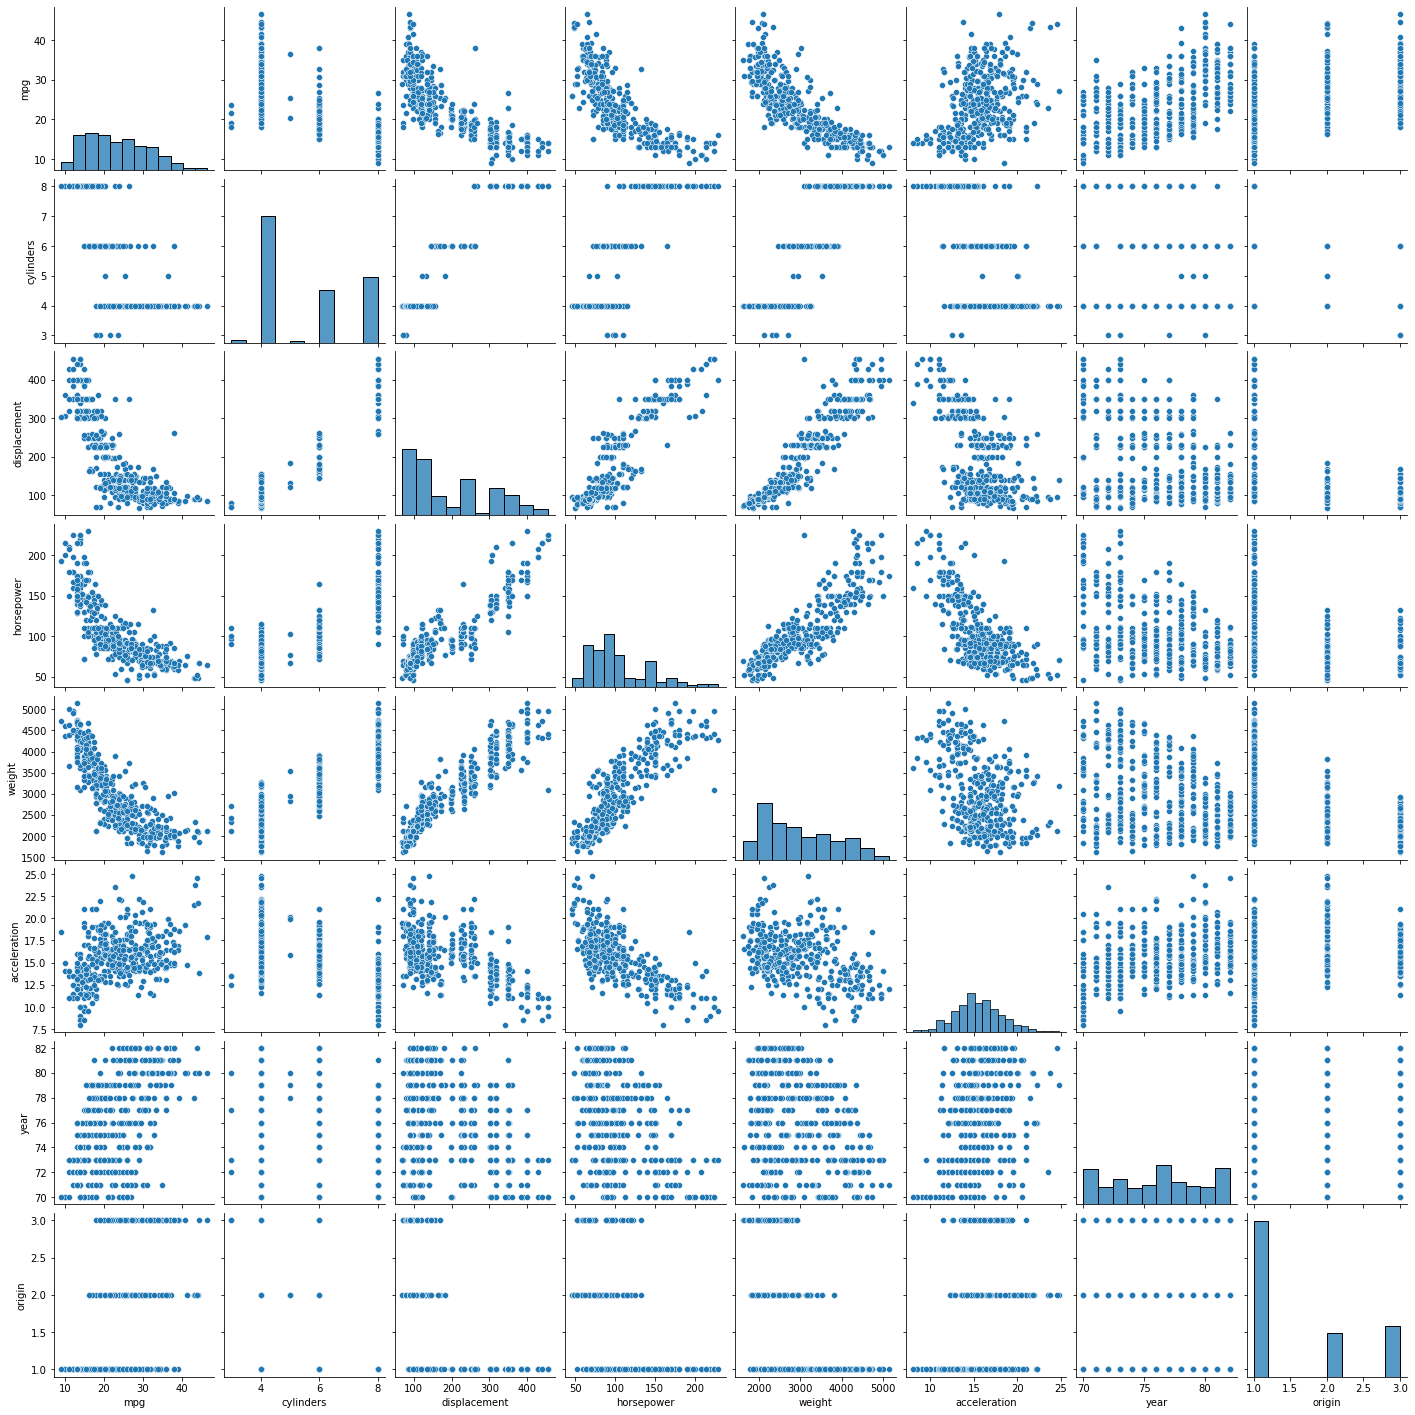

In [214]:
sns.pairplot(data=df)

# Polynomial Regression

In [306]:
##preprocessing 

X = df.drop(['mpg', 'name', 'origin', 'year'], axis=1)#[['cylinders', 'displacement']]

y = df['mpg']

## add polynomial features
#print(X)
#poly = preprocessing.PolynomialFeatures(2)
#XPoly = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out())

### This one actually contains all interacting terms as well; but could create on my own if i didnt want those
k = 3
XPoly = pd.DataFrame(np.hstack((X**(i+1) for i in range(k))), columns = [j==0 and i or i+'^' + str(j+1) for j in range(k) for i in X.columns])
for col in X.columns:
    XPoly[col + '^-1'] = X[col].astype('float64')**-1
    XPoly[col + '^0.5'] = np.sqrt(X[col])

xorg = df[['origin']]
enc = preprocessing.OneHotEncoder()
xorg = pd.DataFrame(enc.fit_transform(xorg).toarray(), columns=['origin1', 'origin2', 'origin3'])


X = pd.concat([XPoly, xorg, df['year'], y], axis=1).dropna()
y = X['mpg'].copy()
X = X.drop('mpg', axis=1)
#X = pd.concat([XPoly, xorg, df['year']], axis=1)
print(X.shape, y.shape)

(387, 29) (387,)


/tmp/ipykernel_1068/2790381962.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  XPoly = pd.DataFrame(np.hstack((X**(i+1) for i in range(k))), columns = [j==0 and i or i+'^' + str(j+1) for j in range(k) for i in X.columns])


In [307]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

['weight^-1']
['weight^-1' 'year']
['weight^-1' 'origin3' 'year']
['displacement^3' 'weight^-1' 'origin3' 'year']
['displacement^2' 'displacement^3' 'weight^-1' 'origin3' 'year']
['displacement^2' 'displacement^3' 'cylinders^0.5' 'weight^-1' 'origin3'
 'year']
['cylinders' 'displacement^2' 'displacement^3' 'cylinders^0.5' 'weight^-1'
 'origin3' 'year']
['cylinders' 'displacement^2' 'displacement^3' 'cylinders^-1'
 'cylinders^0.5' 'weight^-1' 'origin3' 'year']
['cylinders' 'cylinders^2' 'displacement^2' 'displacement^3'
 'cylinders^-1' 'cylinders^0.5' 'weight^-1' 'origin3' 'year']
['cylinders' 'cylinders^2' 'displacement^2' 'cylinders^3' 'displacement^3'
 'cylinders^-1' 'cylinders^0.5' 'weight^-1' 'origin3' 'year']
['cylinders' 'cylinders^2' 'displacement^2' 'cylinders^3' 'displacement^3'
 'cylinders^-1' 'cylinders^0.5' 'weight^-1' 'origin1' 'origin3' 'year']
['cylinders' 'cylinders^2' 'displacement^2' 'cylinders^3' 'displacement^3'
 'cylinders^-1' 'cylinders^0.5' 'weight^-1' 'origin1' 

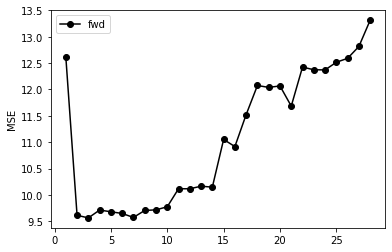

In [308]:
list_res = []

for i in range(len(X.columns)):
    try:
        n_features_to_select = i + 1
        lm = linear_model.LinearRegression()
        feature_names = np.array(X.columns)
        sfs_res = feature_selection.SequentialFeatureSelector(
            lm, n_features_to_select=n_features_to_select, direction="forward", cv=10
        ).fit(X, y)
        list_res.append(feature_names[sfs_res.get_support()])
        print(list_res[-1])
    except:
        print('failed on ' + str(i+1))
res_res = []
for i in list_res:
    lm = linear_model.LinearRegression().fit(X_train[i], y_train)
    res_res.append(np.mean((lm.predict(X_test[i]) - y_test)**2))
plt.figure(1)
plt.plot(np.arange(1, len(res_res)+1, 1), res_res, 'ko-', label='fwd')
plt.legend()
plt.ylabel('MSE')
for i, j, k in zip(list(range(len(list_res))), list_res, res_res):
    print(i,j, k)

9.125204596946089


Text(27.170601851851856, 0.5, 'y residual')

<Figure size 432x288 with 0 Axes>

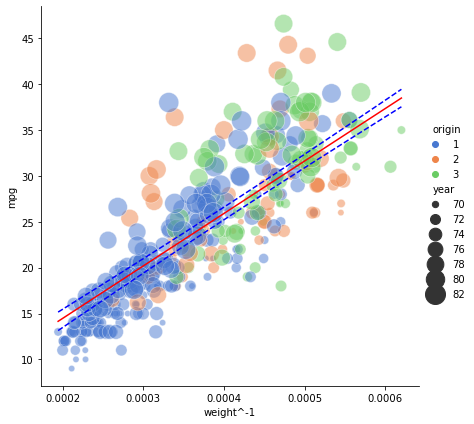

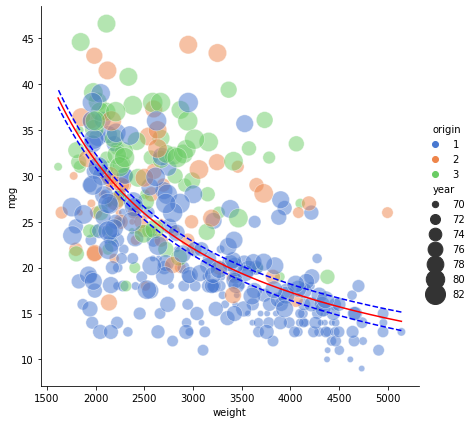

<Figure size 432x288 with 0 Axes>

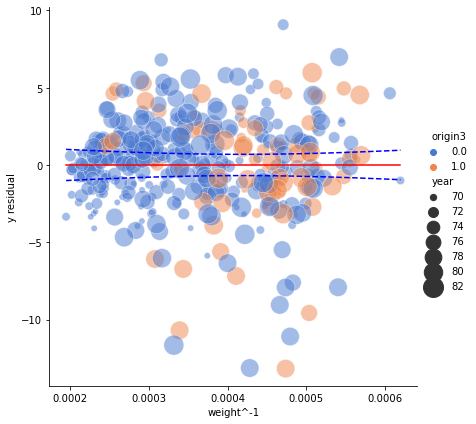

In [309]:
best_n = res_res.index(np.min(res_res)) + 1
best_vars = list_res[best_n - 1]
best_mse = res_res[best_n - 1]
#print(best_n, best_vars, best_mse)
#['weight^-1' 'origin3' 'year'] 9.561899481892057
#This cannot be the only one that works; it seems that Accel, displacement, and weight^-1 are all quite well correlated
#There is a non linear behavior; wt^-1

lm = linear_model.LinearRegression().fit(X[best_vars], y)
print(np.mean((lm.predict(X[best_vars]) - y)**2))
results = sm.OLS(y, sm.add_constant(X[best_vars])).fit()


X_chart = pd.DataFrame(np.zeros([100, 3]), columns=best_vars)
X_chart[best_vars[0]] = np.linspace(np.min(X[best_vars[0]]), np.max(X[best_vars[0]]), 100)
X_chart[best_vars[1]] = 1 #yes origin 3
X_chart[best_vars[2]] = np.average(X[best_vars[2]])

plt.figure(1)
sns.relplot(x=X['weight^-1'], y="mpg", hue="origin", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)
#plt.plot(X_chart[best_vars[0]], lm.predict(X_chart), 'r-')
X_chartsm = pd.concat([pd.DataFrame([np.ones(100)]).transpose(), X_chart], axis=1)
res  = results.get_prediction(exog=X_chartsm)
#print(res.conf_int()[:,0])
plt.plot(X_chart[best_vars[0]], results.predict(X_chartsm), 'r-')
plt.plot(X_chart[best_vars[0]], res.conf_int()[:,0], 'b--')
plt.plot(X_chart[best_vars[0]], res.conf_int()[:,1], 'b--')

plt.figure(2)
sns.relplot(x=X['weight'], y="mpg", hue="origin", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)
#plt.plot(X_chart[best_vars[0]]**-1, lm.predict(X_chart), 'r--')
plt.plot(X_chart[best_vars[0]]**-1, results.predict(X_chartsm), 'r-')
plt.plot(X_chart[best_vars[0]]**-1, res.conf_int()[:,0], 'b--')
plt.plot(X_chart[best_vars[0]]**-1, res.conf_int()[:,1], 'b--')

plt.figure(6)
sns.relplot(x=X['weight^-1'], y=lm.predict(X[best_vars]) - y, hue="origin3", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=X)
#plt.plot(X['weight^-1'], np.zeros(X['weight^-1'].shape), 'r--')
plt.plot(X_chart[best_vars[0]], np.zeros(X_chart[best_vars[0]].shape), 'r-')
plt.plot(X_chart[best_vars[0]], res.conf_int()[:,0] - results.predict(X_chartsm), 'b--')
plt.plot(X_chart[best_vars[0]], results.predict(X_chartsm) - res.conf_int()[:,0], 'b--')
plt.xlabel('weight^-1')
plt.ylabel('y residual')



In [310]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     712.0
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          3.17e-156
Time:                        15:11:04   Log-Likelihood:                -976.97
No. Observations:                 387   AIC:                             1962.
Df Residuals:                     383   BIC:                             1978.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.6053      3.279    -17.872      0.000     -65.053     -52.158
weight^-1   5.722e+04   1671.001     34.243      0.000    5.39e+04    6.05e+04
origin3        0.5504      0.410      1.342      0.180      -0.256       1.357
year           0.8046      0.044     18.168      0.000       0.718       0.892
==============================================================================
Omnibus:                       67.643   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.346
Skew:                           0.856   Prob(JB):                     1.69e-37
Kurtosis:                       5.751   Cond. No.                     8.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 432x288 with 0 Axes>

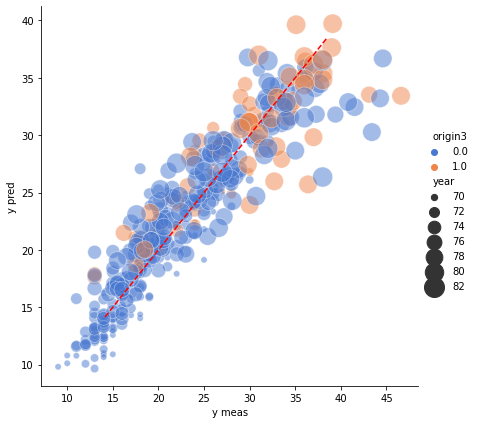

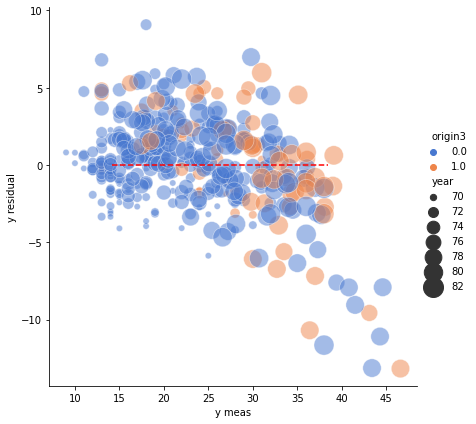

In [311]:
plt.figure(3)
sns.relplot(x=y, y=lm.predict(X[best_vars]), hue="origin3", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=X)
plt.plot(lm.predict(X_chart), lm.predict(X_chart), 'r--')
plt.xlabel('y meas')
plt.ylabel('y pred')

plt.figure(4)
sns.relplot(x=y, y=lm.predict(X[best_vars]) - y, hue="origin3", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=X)
plt.plot(lm.predict(X_chart), np.zeros(lm.predict(X_chart).shape), 'r--')
plt.xlabel('y meas')
plt.ylabel('y residual')

linear_yres = y
linear_res = lm.predict(X[best_vars])


# Splines

In [277]:
##preprocessing 

X = df.drop(['mpg', 'name', 'origin'], axis=1)#, 'origin', 'year'], axis=1)#[['cylinders', 'displacement']]
y = df['mpg']

xorg = df[['origin']]
enc = preprocessing.OneHotEncoder()
xorg = pd.DataFrame(enc.fit_transform(xorg).toarray(), columns=['origin1', 'origin2', 'origin3'])

X = pd.concat([X, xorg, y], axis=1).dropna()
y = X['mpg'].copy()
X = X.drop('mpg', axis=1)
#X = pd.concat([XPoly, xorg, df['year']], axis=1)
print(X.shape, y.shape)

(387, 9) (387,)


In [278]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=2)),
                ('ridge', Ridge(alpha=0.001))])

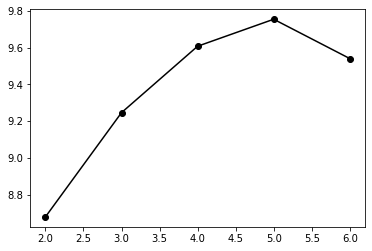

In [279]:
# B-spline with 4 + 3 - 1 = 6 basis functions
n_knots = [2,3,4,5,6]
res_fit = []
for n_knot in n_knots:
    model = pipeline.make_pipeline(preprocessing.SplineTransformer(n_knots=n_knot, degree=3), linear_model.Ridge(alpha=1e-3))#linear_model.LinearRegression())#
    model.fit(X_train, y_train)
    #print(np.mean((model.predict(X_test) - y_test)**2))
    res_fit.append(np.mean((model.predict(X_test) - y_test)**2))
#from above - Linear model - 9.561899481892057
#spline w/ 1E-3 ridge = 9.54; pretty good!
plt.plot(n_knots, res_fit, 'ko-')

#After trying 1E-3 ridge and 2 knots looks the best
model = pipeline.make_pipeline(preprocessing.SplineTransformer(n_knots=2, degree=3), linear_model.Ridge(alpha=1e-3))#linear_model.LinearRegression())#
model.fit(X, y)

Text(28.329166666666666, 0.5, 'y residual')

<Figure size 432x288 with 0 Axes>

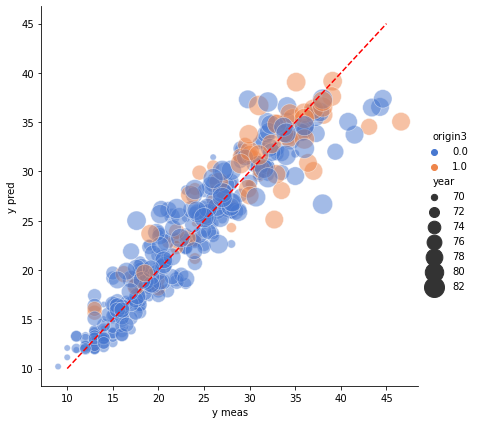

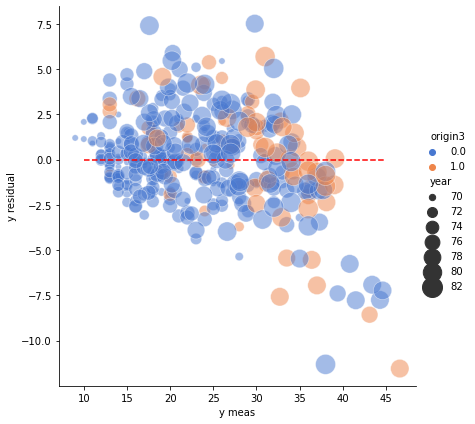

In [304]:
plt.figure(3)
sns.relplot(x=y, y=model.predict(X), hue="origin3", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=X)
plt.plot([10, 45], [10, 45], 'r--')

plt.xlabel('y meas')
plt.ylabel('y pred')

plt.figure(4)
sns.relplot(x=y, y=model.predict(X) - y, hue="origin3", size="year",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=X)
plt.plot([10, 45], [0, 0], 'r--')
plt.xlabel('y meas')
plt.ylabel('y residual')

